In [1]:
import gymnasium as gym
from src.envs.make_env import make_env
from src.agents.REINFORCE_agent import REINFORCEAgent
from src.networks.policy_network import PolicyNetwork, ValueNetwork
from src.training.REINFORCE_trainer import Trainer as REINFORCETrainer
import matplotlib.pyplot as plt
import numpy as np

## Hyperparameters Configuration

Modify these values to tune the training process:

In [2]:
# ============ TRAINING HYPERPARAMETERS ============
# Environment
num_episodes = 3000  # Total number of training episodes
log_interval = 20  # Print stats every N episodes

# Training
learning_rate = 0.0025
gamma = 0.99  # Discount factor

# Baseline (REINFORCE with baseline for variance reduction)
baseline = True
value_learning_rate = 0.001  # Learning rate for value network

## Initialize Components

In [3]:
# Initialize Policy Network
policy_network = PolicyNetwork(input_size=8, output_size=4)

# Initialize Value Network (for baseline)
value_network = ValueNetwork(input_size=8) if baseline else None

# Initialize agent
agent = REINFORCEAgent(action_space=4, policy_network=policy_network)

# Initialize trainer
trainer = REINFORCETrainer(
    policy_network, 
    learning_rate=learning_rate, 
    gamma=gamma,
    baseline=baseline,
    value_network=value_network,
    value_learning_rate=value_learning_rate
)

if baseline:
    print(f"🟣 Using REINFORCE Trainer with Baseline (Policy Gradient + Value Network)")
else:
    print(f"🟣 Using REINFORCE Trainer (Policy Gradient)")

# Create environment
env = make_env(render_mode="rgb_array")

🟣 Using REINFORCE Trainer with Baseline (Policy Gradient + Value Network)


c:\DataScience_Unitn\Lunar_Lander_Reinforcement_Learning\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [4]:
import csv
import os
import pandas as pd
from src.training.episode_outcome import categorize_episode_outcome, get_outcome_icon

# ===== AUTO-INCREMENT RUN ID =====
configs_file = 'runs/all_configs_combined.csv'
runs_file = 'runs/all_runs_combined.csv'

# Read existing configs to find last run_id
df_configs = pd.read_csv(configs_file, dtype={'run_id': str})
last_run_id = df_configs['run_id'].astype(int).max()
new_run_id = str(last_run_id + 1).zfill(2)

print(f"📋 Last run_id found: {last_run_id:02d}")
print(f"🆕 New run_id: {new_run_id}")

# ===== APPEND NEW CONFIG TO all_configs_combined.csv =====
# REINFORCE uses different hyperparameters - fill DQN-specific ones with NA
new_config = {
    'run_id': new_run_id,
    'model_type': 'REINFORCE',
    'num_episodes': num_episodes,
    'log_interval': log_interval,
    'train_every': 'NA',  # Not used in REINFORCE
    'batch_size': 'NA',  # Not used in REINFORCE
    'learning_rate': learning_rate,
    'gamma': gamma,
    'update_mode': 'NA',  # Not used in REINFORCE
    'tau': 'NA',  # Not used in REINFORCE
    'target_update_freq': 'NA',  # Not used in REINFORCE
    'replay_buffer_size': 'NA',  # Not used in REINFORCE
    'epsilon_starting_value': 'NA',  # Not used in REINFORCE
    'epsilon_ending_value': 'NA',  # Not used in REINFORCE
    'epsilon_decay_value': 'NA'  # Not used in REINFORCE
}

# Append to configs file
new_config_df = pd.DataFrame([new_config])
new_config_df.to_csv(configs_file, mode='a', header=False, index=False)
print(f"✅ Config appended to {configs_file}")

# ===== SETUP LOG FILE =====
run_list_dir = 'runs/run_list'
os.makedirs(run_list_dir, exist_ok=True)
log_file = f'{run_list_dir}/run{new_run_id}.csv'

with open(log_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['episode', 'reward', 'length', 'terminated', 'truncated', 'outcome'])

print(f"📁 Log file created: {log_file}")

📋 Last run_id found: 23
🆕 New run_id: 24
✅ Config appended to runs/all_configs_combined.csv
📁 Log file created: runs/run_list/run24.csv


## Training Loop with Visualization

In [5]:
# Training loop with episode outcome logging
episode_rewards = []
episode_outcomes = []
episode_losses = []
episode_logs = []  # Store logs for appending to combined file

print(f"🚀 Starting REINFORCE training for Run {new_run_id}...\n")

for episode in range(num_episodes):
    obs, info = env.reset()
    total_reward = 0.0
    terminated = False
    truncated = False
    episode_length = 0
    final_obs = obs
    last_step_reward = 0.0
    
    # Reset episode data in trainer
    trainer.reset_episode()

    while not (terminated or truncated):
        # Ask agent for action
        action = agent.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Store last step reward (used for outcome classification)
        last_step_reward = reward

        # Store transition in trainer (computes log_prob internally)
        trainer.store_transition(obs, action, reward)

        total_reward += reward
        episode_length += 1
        obs = next_obs
        final_obs = next_obs

    # Update policy at end of episode
    loss = trainer.train_step()
    
    episode_rewards.append(total_reward)
    episode_losses.append(loss)

    # Categorize episode outcome
    outcome = categorize_episode_outcome(final_obs, episode_length, last_step_reward)
    episode_outcomes.append(outcome)

    # Store log entry
    log_entry = {
        'run_id': new_run_id,
        'episode': episode + 1,
        'reward': round(total_reward, 2),
        'length': episode_length,
        'terminated': int(terminated),
        'truncated': int(truncated),
        'outcome': outcome
    }
    episode_logs.append(log_entry)

    # Log to individual run CSV file
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([episode + 1, f"{total_reward:.2f}", episode_length,
                         int(terminated), int(truncated), outcome])

    # Print individual episode result
    outcome_icon = get_outcome_icon(outcome)
    print(
        f"Episode {episode + 1:4d} | Steps: {episode_length:4d} | Reward: {total_reward:7.2f} | "
        f"Loss: {loss:7.4f} | {outcome_icon} {outcome.replace('_', ' ').title()}"
    )

    # Log average reward every N episodes
    if (episode + 1) % log_interval == 0:
        avg_reward = sum(episode_rewards[-log_interval:]) / log_interval
        avg_loss = sum(episode_losses[-log_interval:]) / log_interval

        # Count outcomes in recent window
        recent_outcomes = episode_outcomes[-log_interval:]
        outcome_counts = {
            'success': recent_outcomes.count('landed_success'),
            'crashed': recent_outcomes.count('crashed'),
            'out_of_bounds': recent_outcomes.count('out_of_bounds'),
            'time_limit': recent_outcomes.count('time_limit')
        }

        print(
            f"  └─ Avg Reward: {avg_reward:7.3f} | Avg Loss: {avg_loss:7.4f} | "
            f"Success: {outcome_counts['success']}, "
            f"Crashed: {outcome_counts['crashed']}, "
            f"Out of bounds: {outcome_counts['out_of_bounds']}, "
            f"Time limit: {outcome_counts['time_limit']}"
        )
        print()

env.close()

# ===== APPEND LOGS TO all_runs_combined.csv =====
logs_df = pd.DataFrame(episode_logs)
logs_df.to_csv(runs_file, mode='a', header=False, index=False)
print(f"✅ Logs appended to {runs_file}")

print(f"\n✅ Training completed for Run {new_run_id}!")
print(f"Total episodes: {num_episodes}")

# Final statistics
success_count = episode_outcomes.count('landed_success')
crashed_count = episode_outcomes.count('crashed')
out_of_bounds_count = episode_outcomes.count('out_of_bounds')
time_limit_count = episode_outcomes.count('time_limit')

print(f"\n📊 Episode Outcomes:")
print(f"  🚀 Landed successfully: {success_count} ({100*success_count/num_episodes:.1f}%)")
print(f"  💥 Crashed: {crashed_count} ({100*crashed_count/num_episodes:.1f}%)")
print(f"  📍 Out of bounds: {out_of_bounds_count} ({100*out_of_bounds_count/num_episodes:.1f}%)")
print(f"  ⏱️  Time limit: {time_limit_count} ({100*time_limit_count/num_episodes:.1f}%)")
print(f"\n📁 Individual log saved to: {log_file}")
print(f"📁 Combined logs updated: {runs_file}")
print(f"📁 Configs updated: {configs_file}")

🚀 Starting REINFORCE training for Run 24...

Episode    1 | Steps:   66 | Reward: -185.84 | Loss: -2.8761 | 🔴 Crashed
Episode    2 | Steps:   79 | Reward: -124.34 | Loss:  0.5667 | 🔴 Crashed
Episode    3 | Steps:  101 | Reward: -195.87 | Loss:  0.0078 | 🔴 Crashed
Episode    4 | Steps:   86 | Reward: -114.88 | Loss: -1.6077 | 🔴 Crashed
Episode    5 | Steps:   96 | Reward: -481.62 | Loss:  3.8760 | 🔴 Crashed
Episode    6 | Steps:   72 | Reward: -182.77 | Loss:  0.5463 | 🔴 Crashed
Episode    7 | Steps:  121 | Reward: -239.80 | Loss:  1.6940 | 🔴 Crashed
Episode    8 | Steps:   71 | Reward: -347.64 | Loss: -2.1561 | 🔴 Crashed
Episode    9 | Steps:  110 | Reward: -357.59 | Loss: -0.7669 | 🔴 Crashed
Episode   10 | Steps:  109 | Reward: -379.59 | Loss:  3.0753 | 🔴 Crashed
Episode   11 | Steps:  128 | Reward: -433.18 | Loss: -0.1099 | 🔴 Crashed
Episode   12 | Steps:   61 | Reward:  -88.55 | Loss: -1.9271 | 🔴 Crashed
Episode   13 | Steps:   81 | Reward: -539.90 | Loss:  2.6705 | 🟡 Out Of Bounds


## Plot Training Progress

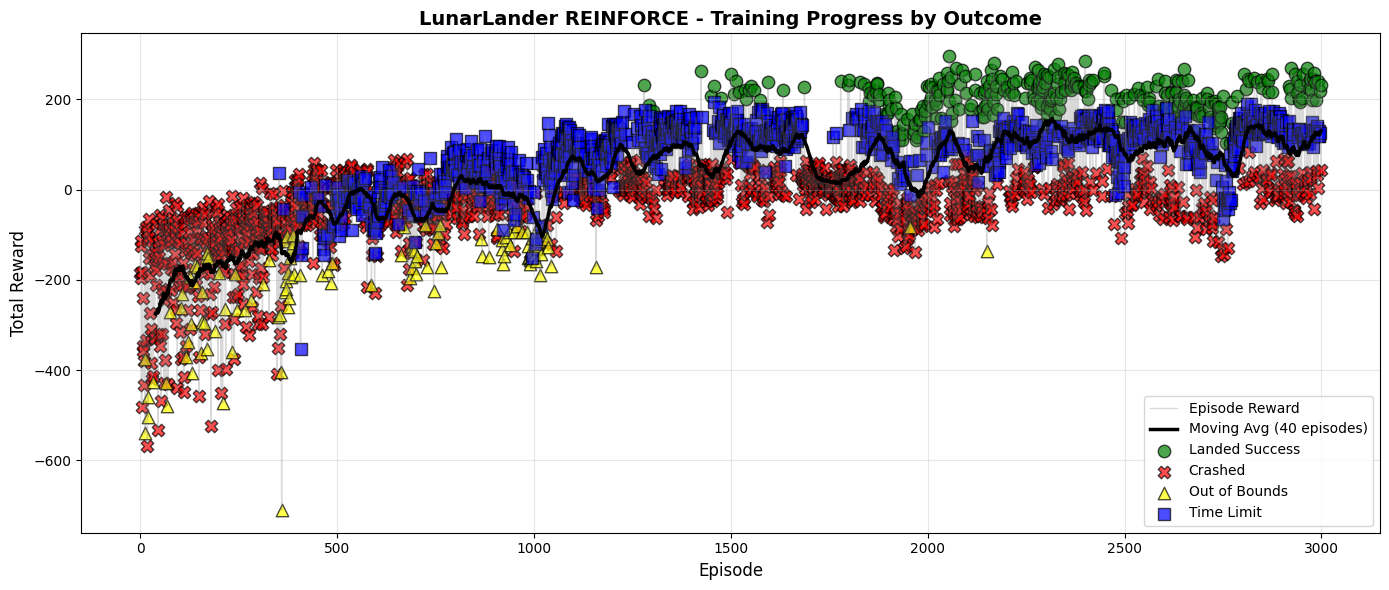


📊 Training Statistics:
  Average Reward: 26.718
  Max Reward: 295.880
  Min Reward: -710.182
  Std Dev: 124.849


In [6]:
# Plot episode rewards over time with outcome colors and different markers
fig, ax = plt.subplots(figsize=(14, 6))

# Base line plot
ax.plot(episode_rewards, alpha=0.3, label='Episode Reward', linewidth=1, color='gray')

# Plot moving average
window = 40
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(episode_rewards)), moving_avg, linewidth=2.5, 
         label=f'Moving Avg ({window} episodes)', color='black')

# Color and marker mapping for outcomes
outcome_styles = {
    'landed_success': {'color': 'green', 'marker': 'o', 'label': 'Landed Success'},
    'crashed': {'color': 'red', 'marker': 'X', 'label': 'Crashed'},
    'out_of_bounds': {'color': 'yellow', 'marker': '^', 'label': 'Out of Bounds'},
    'time_limit': {'color': 'blue', 'marker': 's', 'label': 'Time Limit'}
}

# Plot scatter points with different markers for each outcome
for outcome, style in outcome_styles.items():
    episodes = [i for i, o in enumerate(episode_outcomes) if o == outcome]
    rewards = [episode_rewards[i] for i in episodes]
    ax.scatter(episodes, rewards, c=style['color'], marker=style['marker'], 
              label=style['label'], s=80, alpha=0.7, edgecolors='black', linewidth=1)

ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Total Reward', fontsize=12)
ax.set_title('LunarLander REINFORCE - Training Progress by Outcome', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Training Statistics:")
print(f"  Average Reward: {np.mean(episode_rewards):.3f}")
print(f"  Max Reward: {np.max(episode_rewards):.3f}")
print(f"  Min Reward: {np.min(episode_rewards):.3f}")
print(f"  Std Dev: {np.std(episode_rewards):.3f}")

## Watch Trained Agent in Action

In [11]:
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
import glob
import gymnasium as gym
import torch

env = gym.make("LunarLander-v3", render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder="videos",
    episode_trigger=lambda episode_id: True,
    name_prefix="trained_agent_reinforce"
)

obs, info = env.reset()

final_reward = 0.0
terminated = False
truncated = False
episode_steps = 0
final_obs = obs
last_step_reward = 0.0

# Use greedy policy (no sampling, just argmax)
while not (terminated or truncated):
    # Select best action (deterministic)
    with torch.no_grad():
        probs = policy_network.predict(obs)
        action = torch.argmax(probs, dim=-1).item()
    
    obs, reward, terminated, truncated, info = env.step(action)

    final_reward += reward
    episode_steps += 1
    final_obs = obs
    last_step_reward = reward

env.close()

# Categorize episode outcome
outcome = categorize_episode_outcome(
    final_obs,
    episode_steps,
    last_step_reward
)
outcome_icon = get_outcome_icon(outcome)

print(f"\n🎬 Trained Agent Performance:")
print(f" Total Reward: {final_reward:.3f}")
print(f" Episode Steps: {episode_steps}")
print(f" Outcome: {outcome_icon} {outcome.replace('_', ' ').title()}")

# Pick the newest video
video_path = max(glob.glob("videos/*.mp4"), key=lambda p: p)

HTML(f"""
<video width="600" controls autoplay loop>
    <source src="{video_path}" type="video/mp4">
</video>
""")


🎬 Trained Agent Performance:
 Total Reward: 83.877
 Episode Steps: 1000
 Outcome: 🔵 Time Limit
